## 统计分析

通过指定统计分析字段，得到每个特征的p_value，所有的p_value计算都是基于Ttest计算。支持指定不同的分组`group`，例如train、val、test等分组统计。

对于两大类不同的特征

1. 离散特征，统计数量以及占比。
2. 连续特征，统计均值、方差。

In [1]:
import pandas as pd
import numpy as np
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.utils import print_join_info

task = get_param_in_cwd('task_column') or 'label'
p_value = get_param_in_cwd('p_value') or 0.05
# 修改成自己临床数据的文件。
test_data = pd.read_csv(get_param_in_cwd('clinic_file'))
stats_columns_settings = get_param_in_cwd('stats_columns')
continuous_columns_settings = get_param_in_cwd('continuous_columns')
mapping_columns_settings = get_param_in_cwd('mapping_columns')
test_data = test_data[[c for c in test_data.columns if c != task]]
test_data['ID'] = test_data['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
group_info = pd.read_csv(get_param_in_cwd('label_file'))
print_join_info(test_data, group_info)
test_data = pd.merge(test_data, group_info, on='ID', how='inner')
test_data

[2025-08-30 01:14:09 - <frozen onekey_algo.custom.utils>:  60]	INFO	ID特征完全匹配！


,ID,CLN,RAD,label,group
0,banlimei5.nii.gz,0,0.735,0,test
1,bicongzhi5.nii.gz,0,0.487,1,train
2,caoyongling5.nii.gz,0,0.487,0,train
3,chenfuxiu5.nii.gz,0,0.436,1,train
4,chenyafeng5.nii.gz,0,0.513,1,train
...,...,...,...,...,...
95,zengming5.nii.gz,0,0.450,1,train
96,zhanxiulin5.nii.gz,0,0.504,0,train
97,zhaoguichun5.nii.gz,0,0.736,0,train
98,zhongguoxiong5.nii.gz,0,0.462,1,train


# 特征名称处理

去掉所有特征名称中的特殊字符。

In [2]:
import re

def map_cnames(x):
    x = re.split('[（|(]', x)[0]
    x = x.replace('-', '_').replace(' ', '_').replace('>', '').replace('/', '_')
    return x.strip()

test_data.columns = list(map(map_cnames, test_data.columns))
test_data.columns

Index(['ID', 'CLN', 'RAD', 'label', 'group'], dtype='object')

# 分析数据

获取待分析的特征列名，如未制定，自动侦测。

In [3]:
stats_columns = stats_columns_settings or list(test_data.columns[1:-2])
test_data = test_data.copy()[['ID'] + stats_columns + ['group', 'label']]
test_data

,ID,CLN,RAD,group,label
0,banlimei5.nii.gz,0,0.735,test,0
1,bicongzhi5.nii.gz,0,0.487,train,1
2,caoyongling5.nii.gz,0,0.487,train,0
3,chenfuxiu5.nii.gz,0,0.436,train,1
4,chenyafeng5.nii.gz,0,0.513,train,1
...,...,...,...,...,...
95,zengming5.nii.gz,0,0.450,train,1
96,zhanxiulin5.nii.gz,0,0.504,train,0
97,zhaoguichun5.nii.gz,0,0.736,train,0
98,zhongguoxiong5.nii.gz,0,0.462,train,1


# 特征队列映射

所有需要进行特征映射的队列，range未制定，可以进行自动判断。

In [4]:
mapping_columns = mapping_columns_settings or [c for c in test_data.columns[1:-2] if test_data[c].dtype == object]
mapping_columns

[]

# 数据映射

针对所有非数值形式的数据，可以进行类别映射。

In [5]:
from onekey_algo.custom.utils import map2numerical

data, mapping = map2numerical(test_data, mapping_columns=mapping_columns)
mapping

{}

In [6]:
from onekey_algo.custom.components.comp1 import fillna

data = fillna(data, fill_mod='50%')
continuous_columns = []
for col in test_data.columns:
    if test_data[col].apply(lambda x: x.is_integer() if isinstance(x, float) else False).all():
        test_data[col] = test_data[col].astype(int)

for c in stats_columns:
#     print(c, np.unique(test_data[c]), test_data[c].dtype)
    if len(np.unique(test_data[c])) > 5 or not np.int8 <= test_data[c].dtype <= np.int64:
        continuous_columns.append(c)
        
continuous_columns = continuous_columns_settings or continuous_columns
continuous_columns = [c for c in continuous_columns if c not in ('differentation')]
continuous_columns

['RAD']

# 缺失值填充

In [7]:
import os
os.makedirs('data', exist_ok=True)
data.to_csv('data/clinical.csv', index=False)
data

,ID,CLN,RAD,group,label
0,banlimei5.nii.gz,0,0.735,test,0
1,bicongzhi5.nii.gz,0,0.487,train,1
2,caoyongling5.nii.gz,0,0.487,train,0
3,chenfuxiu5.nii.gz,0,0.436,train,1
4,chenyafeng5.nii.gz,0,0.513,train,1
...,...,...,...,...,...
95,zengming5.nii.gz,0,0.450,train,1
96,zhanxiulin5.nii.gz,0,0.504,train,0
97,zhaoguichun5.nii.gz,0,0.736,train,0
98,zhongguoxiong5.nii.gz,0,0.462,train,1


### 统计分析

支持两种格式数据，分别对应`pretty`参数的`True`和`False`, 当为`True`时，输出的是表格模式，反之则为dict数据。

```python
def clinic_stats(data: DataFrame, stats_columns: Union[str, List[str]], label_column='label',
                 group_column: str = None, continuous_columns: Union[str, List[str]] = None,
                 pretty: bool = True) -> Union[dict, DataFrame]:
    """

    Args:
        data: 数据
        stats_columns: 需要统计的列名
        label_column: 二分类的标签列，默认`label`
        group_column: 分组统计依据，例如区分训练组、测试组、验证组。
        continuous_columns: 那些列是连续变量，连续变量统计均值方差。
        pretty: bool, 是否对结果进行格式美化。

    Returns:
        stats DataFrame or json

    """
```

In [8]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column=task, 
                     group_column='group', 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv(f'data/stats_{task}.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,train-label=ALL,train-label=0,train-label=1,pvalue,test-label=ALL,test-label=0,test-label=1,pvalue
0,RAD,0.479±0.170,0.578±0.130,0.402±0.158,<0.001,0.501±0.120,0.554±0.110,0.465±0.117,0.053
0,CLN,,,,0.838,,,,1.0
1,0,69(86.250),31(88.571),38(84.444),,19(95.000),8(100.000),11(91.667),
2,1,11(13.750),4(11.429),7(15.556),,1(5.000),null,1(8.333),


In [9]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column='group', 
                     group_column=None, 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv('data/statics.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,-label=ALL,-label=test,-label=train,pvalue
0,RAD,0.483±0.161,0.501±0.120,0.479±0.170,0.842
0,CLN,,,,0.489
1,0,88(88.000),19(95.000),69(86.250),
2,1,12(12.000),1(5.000),11(13.750),


# 单因素多因素分析

单因素，步进多因素分析
```python
def uni_multi_variable_analysis(data: pd.DataFrame, features: Union[str, List[str]] = None, label_column: str = 'label',
                                need_norm: Union[bool, List[bool]] = False, alpha=0.1,
                                p_value4multi: float = 0.05, save_dir: Union[str] = None, prefix: str = '',
                                **kwargs):
    """
    单因素，步进多因素分析，使用p_value4multi参数指定多因素分析的阈值
    Args:
        data: 数据
        features: 需要分析的特征，默认除了ID和label_column列，其他的特征都进行分析。
        label_column: 目标列
        need_norm: 是否标准化所有分析的数据, 默认为False
        alpha: CI alpha, alpha/2 %；默认为0.1即95% CI
        p_value4multi: 参数指定多因素分析的阈值，默认为0.05
        save_dir: 保存位置
        prefix: 前缀
        **kwargs:

    Returns:

    """
 ```

,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
CLN,0.560,-0.471,1.591,1.750,0.624,4.909,0.372
RAD,-0.209,-0.934,0.517,0.812,0.393,1.677,0.636


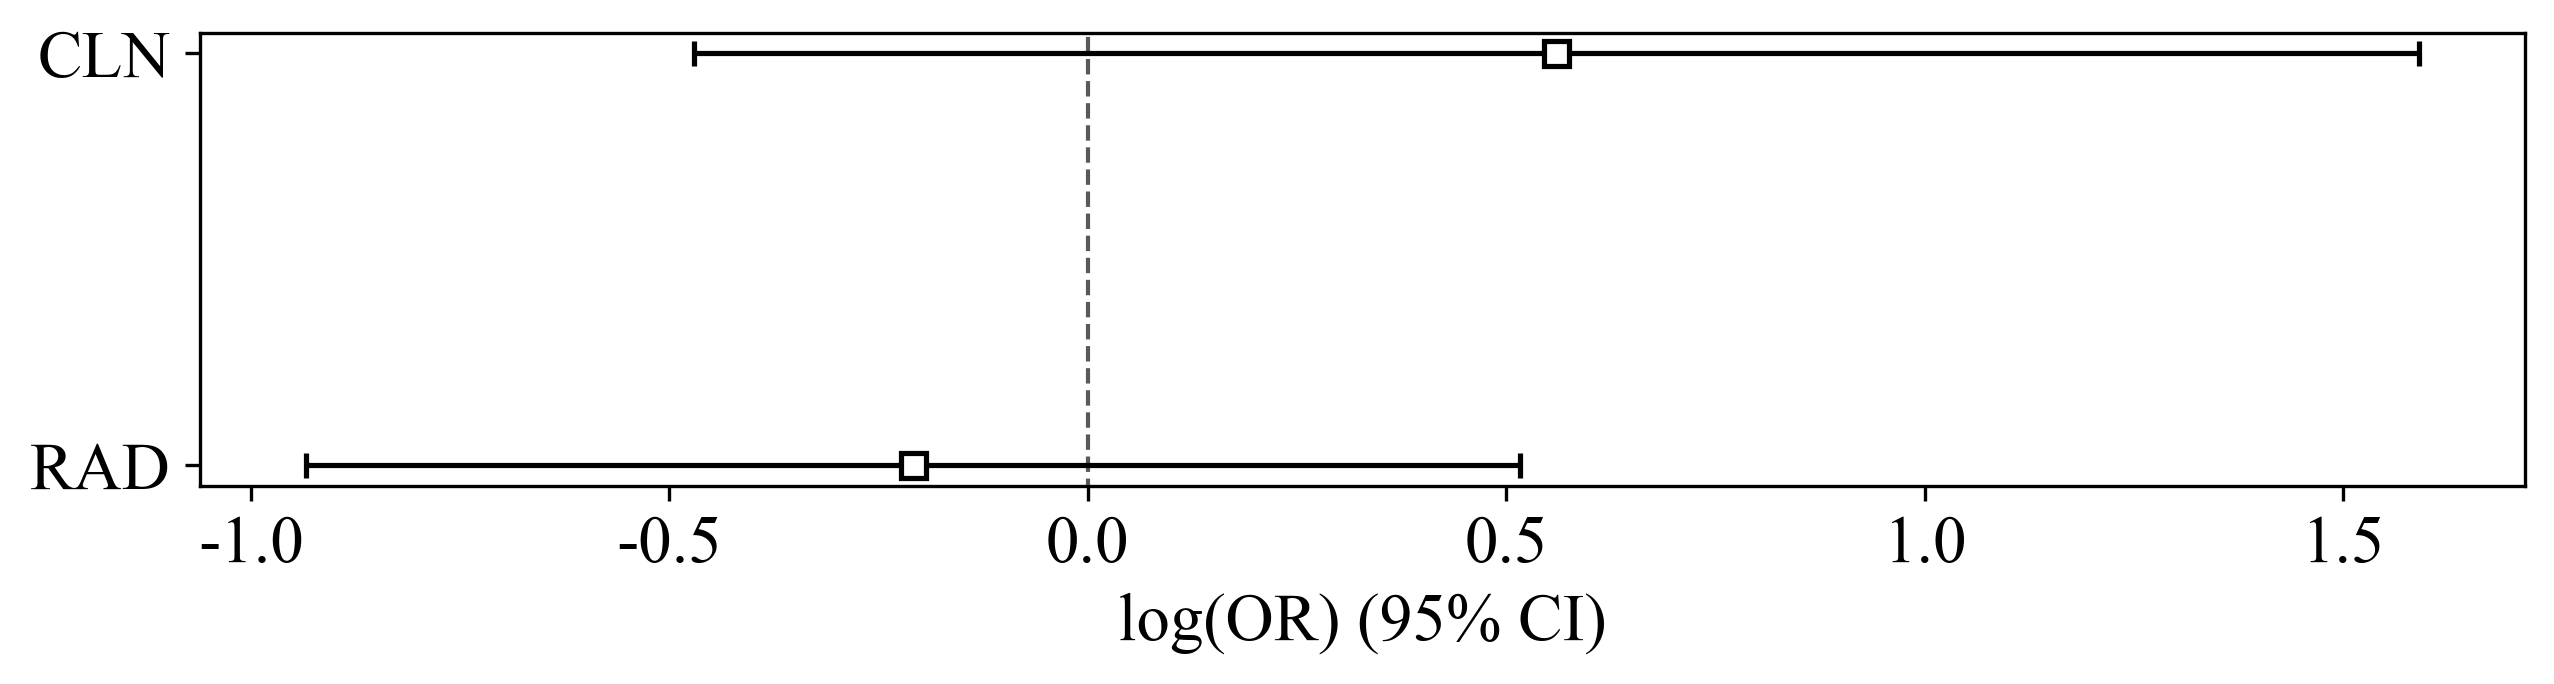

[2025-08-30 01:14:09 - <frozen onekey_algo.custom.components.comp1>:1911]	WARNING	没有通过单因素分析，找到任何pvalue<0.05的特征！


In [10]:
from onekey_algo.custom.components.comp1 import uni_multi_variable_analysis                        

uni_multi_variable_analysis(data[data['group'] == 'train'], stats_columns, save_dir='img', p_value4multi=p_value, algo='logit')

In [11]:
uni_v = pd.read_csv('img/multivariable_reg.csv')
uni_v = uni_v[uni_v['p_value'] <= 0.05]
sel_data = data[['ID'] + list(uni_v['feature_name']) + ['group', 'label']]
sel_data.to_csv('data/clinic_sel.csv', index=False)
sel_data

KeyError: "['M'] not in index"

In [ ]:
uni = pd.read_csv('img/univariable_reg.csv')
uni = uni[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
multi = pd.read_csv('img/multivariable_reg.csv')
multi = multi[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
info = pd.merge(uni, multi, on='feature_name', how='left', suffixes=['_UNI', '_MULTI']).applymap(lambda x: '' if pd.isna(x) else x)
info.to_csv('results/unimulti.csv', index=False)
info